In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
X = pd.read_csv("data.csv")

In [3]:
#Preprocessing
X.drop("country", axis=1, inplace=True)
X = X.astype(float)

In [4]:
# Normalizing the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Outlier removal based on Z-score
X = X[(X.abs() <= 3).all(axis=1)]

In [5]:
# Convert to NumPy array
X_array = X.to_numpy()

In [6]:
def hierarchical_clustering(X):
    n = X.shape[0]
    clusters = {i: [i] for i in range(n)}
    distances = np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=2)
    np.fill_diagonal(distances, np.inf)  # Avoid self-linking

    linkage_matrix = []

    current_cluster_id = n

    while len(clusters) > 1:
        # Find the closest pair of clusters
        min_dist = np.inf
        to_merge = (None, None)

        for i in clusters:
            for j in clusters:
                if i != j:
                    dist = np.linalg.norm(np.mean(X[clusters[i]], axis=0) - np.mean(X[clusters[j]], axis=0))

                    if dist < min_dist:
                        min_dist = dist
                        to_merge = (i, j)

        # Merge the closest clusters
        i, j = to_merge
        new_cluster = clusters[i] + clusters[j]
        del clusters[i]
        del clusters[j]
        clusters[current_cluster_id] = new_cluster

        # Update linkage matrix
        linkage_matrix.append([i, j, min_dist, len(new_cluster)])

        current_cluster_id += 1

    return np.array(linkage_matrix)


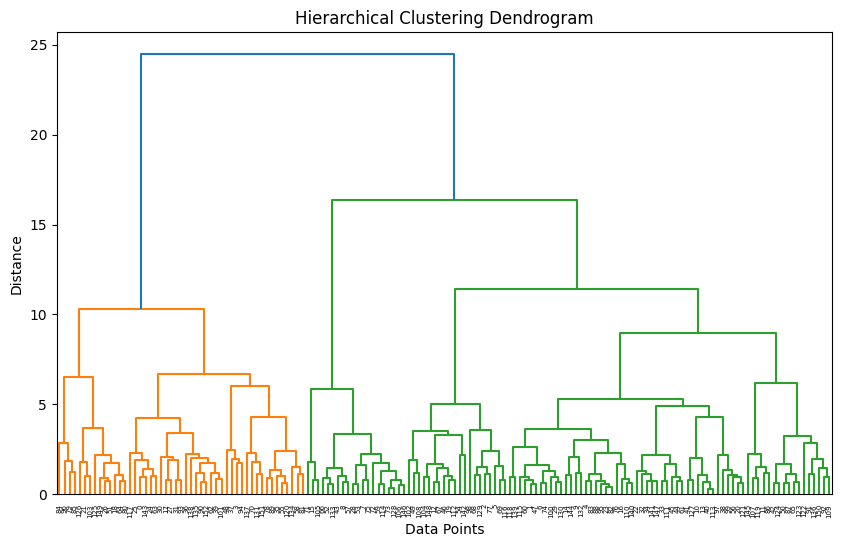

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
linkage_matrix = linkage(X_array, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


Cluster assignments: [1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1
 1 2 1 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 1 1 1 2 2 2 2 2 1 2 2 2
 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 1 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 1 2 2 2 2
 2 1 2 1 1]


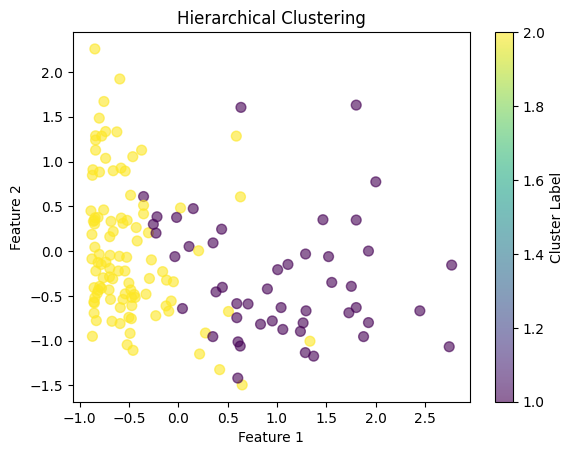

In [8]:
from scipy.cluster.hierarchy import fcluster

# Get clusters
n_clusters = 2
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')


# Print cluster assignments
print("Cluster assignments:", clusters)

# Visualize clusters
plt.scatter(X_array[:, 0], X_array[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6)
plt.title("Hierarchical Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")
plt.show()


In [9]:
#Matrices
def silhouette_score_optimized(X, labels):
    unique_labels = np.unique(labels)
    n_samples = X.shape[0]
    silhouette_scores = []

    for i in range(n_samples):
        same_cluster = X[labels == labels[i]]
        a_i = np.mean(np.linalg.norm(same_cluster - X[i], axis=1))

        b_i = np.inf
        for label in unique_labels:
            if label != labels[i]:
                other_cluster = X[labels == label]
                b_i = min(b_i, np.mean(np.linalg.norm(other_cluster - X[i], axis=1)))

        silhouette_scores.append((b_i - a_i) / max(a_i, b_i))

    return np.mean(silhouette_scores)

sil_score = silhouette_score_optimized(X_array, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.3078


In [10]:
y = clusters

In [11]:
#Train Test Split
ratio = 0.8

rows = X_array.shape[0]
train_size = int(ratio*rows)

X_train = X_array[0:train_size]
X_test = X_array[train_size:]

y_train = y[0:train_size]
y_test = y[train_size:]

In [12]:
from collections import Counter
from math import sqrt

def euclidean_distance(point1, point2):
    return sqrt(np.sum((point1 - point2) ** 2))

class KNN:
    def __init__(self, k=2):
        self.k = k 

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)
        
    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        k_indices = np.argsort(distances)[:self.k]
        
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [13]:
knn = KNN(k=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(y_pred)
print("-----")
print(y_test)

[2 2 2 1 1 2 2 2 2 1 2 2 2 1 2 1 1 2 2 2 1 1 2 2 2 2 2 1 1 1 1]
-----
[2 2 2 1 1 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 1 2 2 2 2 2 1 2 1 1]


In [14]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred, positive_class):
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    fp = np.sum((y_pred == positive_class) & (y_true != positive_class))
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall(y_true, y_pred, positive_class):
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    fn = np.sum((y_pred != positive_class) & (y_true == positive_class))
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred, positive_class=1)
rec = recall(y_test, y_pred, positive_class=1)
f1 = f1_score(prec, rec)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9032
Precision: 0.8333
Recall: 0.9091
F1 Score: 0.8696
